In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [4]:
from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize
from accelerate import Accelerator
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
import timeit
from PIL import Image
import numpy as np
import cv2
import os
import lovely_tensors as lt
lt.monkey_patch()

Helper functions

In [26]:
def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.cpu().numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

In [36]:
def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

In [34]:
def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.cpu().numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

In [35]:
def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

In [37]:
def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

In [38]:
def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]

In [39]:
colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]

In [5]:
pdir = Path.cwd().parent

Dataset definition

In [63]:
IMG_DIR = "/ext/stalla/LabelAnything/images/train2017"
ANNOTATIONS_DIR = os.path.join(pdir, "data/annotations/instances_train2017.json")
EMBEDDINGS_DIR = "/ext/stalla/LabelAnything/embeddings"


In [7]:
preprocess = Compose([
    CustomResize(1024),
    PILToTensor(),
    CustomNormalize()
])

In [65]:
dataset = LabelAnythingDataset(
    {
        "coco20i": {
            "name": "coco",
            "instances_path": ANNOTATIONS_DIR,
            "img_dir": IMG_DIR,
            "split": "val",
            "val_fold_idx": 0,
            "n_folds": 4,
            "n_shots": 1,
            "preprocess": preprocess,
            "prompt_types": ["mask"]
        }
    }, {}
)
accelerator = Accelerator()
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 8], [1, 4], [1, 2], [1, 1]],
        num_processes=1,
        shuffle=False,
)
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)
dataloader = accelerator.prepare(dataloader)

Loading dataset annotations from /home/pasquale/projects/LabelAnything/data/annotations/instances_train2017.json...


In [99]:
(batch, gt), _ = next(iter(dataloader))

In [101]:
unbatched = {k : v[0] for k, v in batch.items()}

In [102]:
images = [
    draw_all(
        get_image(unbatched["images"][i]),
        unbatched["prompt_masks"][i],
        unbatched["prompt_bboxes"][i],
        unbatched["prompt_points"][i],
        colors
    )
    for i in range(unbatched["images"].shape[0])
]

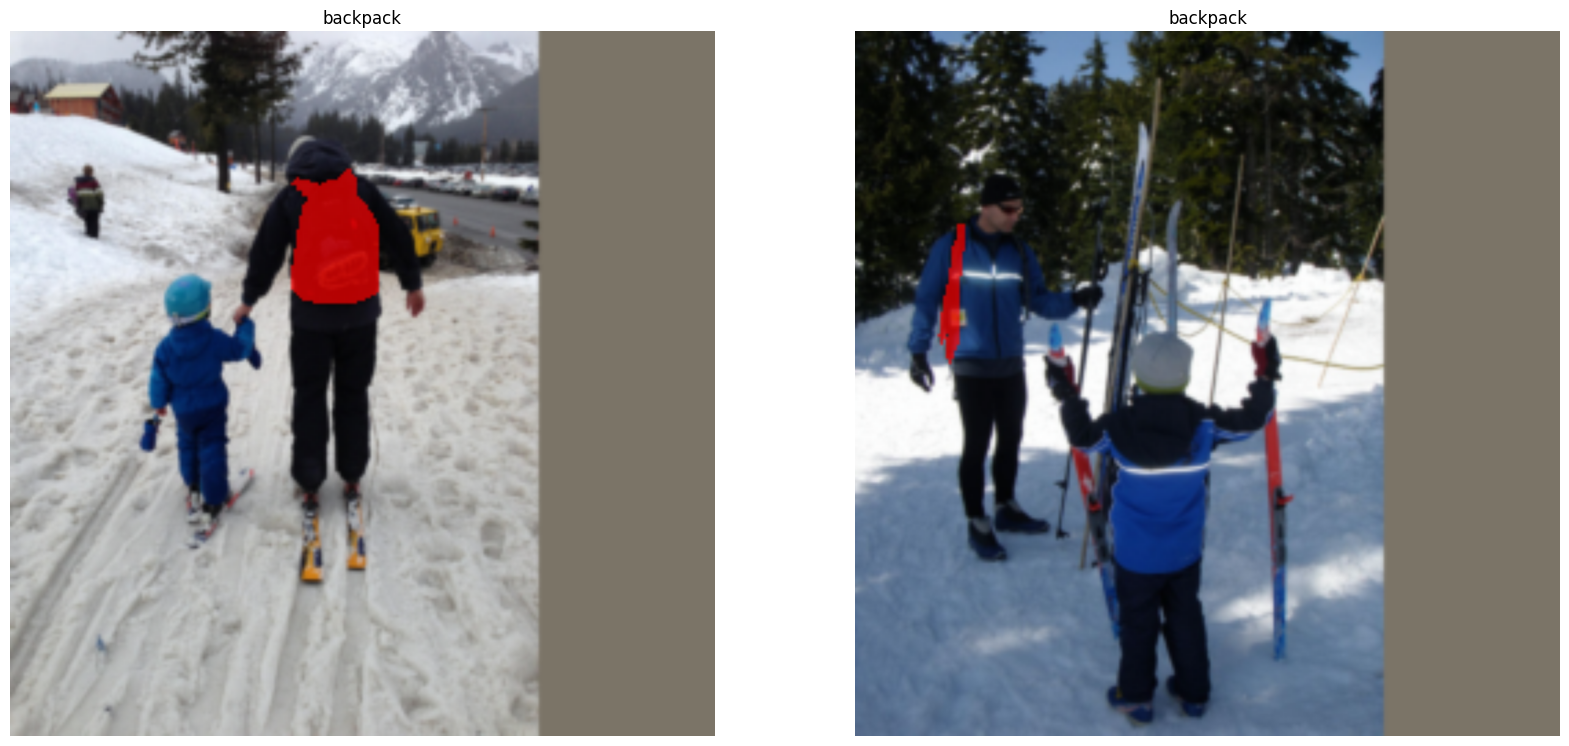

In [103]:
num_images = len(images)
cols = 2
rows = (num_images + 1) // cols

fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

for i, img in enumerate(images):
    cats = [dataset.categories["coco20i"][cat]["name"] for cat in unbatched["classes"][i]]
    if rows == 1:
        ax[i % cols].imshow(img)
        ax[i % cols].set_title(", ".join(cats))
        ax[i % cols].axis("off")
    else:
        ax[i // cols, i % cols].imshow(img)
        ax[i // cols, i % cols].set_title(", ".join(cats))
        ax[i // cols, i % cols].axis("off")
    
plt.show()

---
Load model

In [95]:
from label_anything.models import build_lam_no_vit
from label_anything.experiment.substitution import Substitutor
from safetensors.torch import load_file

In [106]:

model = build_lam_no_vit()
model = accelerator.prepare(model)

In [79]:
image_ids = batch['image_ids']
z_filled = [[str(image_id).zfill(12) for image_id in item] for item in image_ids]
flattened = [item for sublist in z_filled for item in sublist]
print(" ".join(flattened))

000000524338 000000176912


In [90]:
item = image_ids[0]
safetensors = []
for id in item:
    safetensors.append(load_file(f"{EMBEDDINGS_DIR}/{str(id).zfill(12)}.safetensors")['embedding'])
    
safetensors = torch.stack(safetensors).unsqueeze(0)
safetensors = safetensors.to(accelerator.device)
batch['embeddings'] = safetensors
        

 Load the substitutor

In [104]:
substitutor = Substitutor(substitute=False)
substitutor.reset((batch, gt))
input, one_gt = next(iter(substitutor))

In [107]:
seg = model(batch)

TypeError: 'NoneType' object is not callable